In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

os.chdir("/content/drive/MyDrive/python/noisy")

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input,Cropping1D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
import numpy as np
import IPython.display
import glob
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
clean_train = np.load('data/12k-batch/clean_train.npy')
pure = np.load('data/12k-batch/pure_part3.npy')

print(f"Clean Train Shape: {clean_train.shape}")
print(f"Noisy Train Shape: {pure.shape}")


Clean Train Shape: (45078, 12000, 1)
Noisy Train Shape: (40000, 12000, 2)


In [ ]:
# Stereo'yu Mono'ya çevir (eğer stereo ise)
if clean_train.ndim == 3 and clean_train.shape[-1] == 2:
    clean_train = np.mean(clean_train, axis=-1)
if pure.ndim == 3 and pure.shape[-1] == 2:
    pure = np.mean(pure, axis=-1)


In [ ]:

pure = pure[..., np.newaxis]


# Boyutları eşitle
min_len = min(clean_train.shape[0], pure.shape[0])
min_sample_len = min(clean_train.shape[1], pure.shape[1])

clean_train = clean_train[:min_len, :min_sample_len]
pure = pure[:min_len, :min_sample_len]

# Gürültüyü %30 oranında karıştır
noisy_mixed = clean_train + 0.5 * pure



In [ ]:
print(f"Clean Train Shape: {clean_train.shape}")
print(f"Noisy Train Shape: {pure.shape}")

Clean Train Shape: (40000, 12000, 1)
Noisy Train Shape: (40000, 12000, 1)


In [ ]:
import numpy as np
from IPython.display import Audio

# Örnekleme oranı
sampling_rate = 16000

# Boyutları kontrol edip sıkıştır
clean_data = clean_train.squeeze()
noisy_data = noisy_mixed.squeeze()

# İlk 10 örneği birleştir
clean_concat = np.concatenate(clean_data[4050:4100], axis=0)
noisy_concat = np.concatenate(noisy_data[4050:4100], axis=0)

# Ses verisini -1.0 ile 1.0 arasına normalize et
def normalize_audio(audio):
    max_val = np.max(np.abs(audio))
    return audio / max_val if max_val != 0 else audio

clean_concat = normalize_audio(clean_concat)
noisy_concat = normalize_audio(noisy_concat)

# 🎧 Oynat
print("🎧 Clean Audio (first 10 samples concatenated):")
display(Audio(clean_concat, rate=sampling_rate))

print("🎧 Noisy Audio (first 10 samples concatenated):")
display(Audio(noisy_concat, rate=sampling_rate))


🎧 Clean Audio (first 10 samples concatenated):


🎧 Noisy Audio (first 10 samples concatenated):


In [ ]:
clean_combined = np.concatenate((np.load('data/12k-batch/clean_train.npy'),
                                #  np.load('data/12k-batch/clean_train2.npy'),
                                 ), axis=0)

noisy_combined = np.concatenate((np.load('data/12k-batch/noisy_train.npy'),
                                #  np.load('data/12k-batch/noisy_train2.npy')
                                 ), axis=0)

print(f"Clean Combined Shape: {clean_combined.shape}")
print(f"Noisy Combined Shape: {noisy_combined.shape}")

Clean Combined Shape: (45078, 12000, 1)
Noisy Combined Shape: (45078, 12000, 1)


In [ ]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GRU, Bidirectional
from tensorflow.keras.layers import Conv1DTranspose, Concatenate, Dropout, TimeDistributed
from tensorflow.keras.models import Model

def build_generator(input_shape=(12000, 1)):
    inp = Input(shape=input_shape)

    # --- Encoder ---
    x = Conv1D(16, 15, strides=2, padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    c1 = x

    x = Conv1D(32, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    c2 = x

    x = Conv1D(64, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    c3 = x

    x = Conv1D(128, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    c4 = x

    x = Conv1D(256, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    c5 = x

    # --- Bottleneck with Bidirectional GRU ---
    x = Bidirectional(GRU(128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)


    x = TimeDistributed(Dense(128, activation='relu'))(x)


    # --- Decoder ---
    x = Conv1DTranspose(256, 15, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([c5, x])

    x = Conv1DTranspose(128, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([c4, x])

    x = Conv1DTranspose(64, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([c3, x])

    x = Conv1DTranspose(32, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([c2, x])

    x = Conv1DTranspose(16, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Concatenate()([c1, x])

    x = Conv1DTranspose(8, 15, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # inp ile tekrar concatenate ETMİYORUZ artık!

    out = Conv1DTranspose(1, 15, strides=1, padding='same', activation='linear')(x)

    model = Model(inputs=inp, outputs=out, name="GRU_Generator")
    return model


In [ ]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, Flatten, Dense
from tensorflow.keras.models import Model

def build_discriminator(input_shape=(12000, 1)):
    inp = Input(shape=input_shape)

    x = Conv1D(16, 15, strides=4, padding='same')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(32, 15, strides=4, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(64, 15, strides=4, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(128, 15, strides=4, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU(alpha=0.2)(x)
    out = Dense(1, activation='sigmoid')(x)  # 0 (fake) or 1 (real)

    model = Model(inputs=inp, outputs=out, name="Discriminator")
    return model


In [ ]:
from keras.models import load_model
generator = load_model('dg_gru_original-100.hdf5', compile=False)



In [ ]:



# generator = build_generator(input_shape=(12000, 1))
discriminator = build_discriminator(input_shape=(12000, 1))

generator.summary()
discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "GRU_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 12000, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 6000, 16)  │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6000, 16)  │         64 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_11       │ (None, 6000, 16)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 3000, 32)  │      7,712 │ activation_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 3000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1500, 64)  │     30,784 │ activation_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 750, 128)  │    123,008 │ activation_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 750, 128)  │        512 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 750, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 375, 256)  │    491,776 │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 375, 256)  │      1,024 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 375, 256)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 375, 256)  │    296,448 │ activation_15[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 375, 256)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 375, 128)  │    123,648 │ dropout_2[0][0] 

 Total params: 2,895,729 (11.05 MB)

 Trainable params: 2,893,729 (11.04 MB)

 Non-trainable params: 2,000 (7.81 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3000, 16)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3000, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 3000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 750, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 750, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 750, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 188, 64)        │        30,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 188, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 188, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 47, 128)        │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 47, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6016)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       385,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,873 (2.09 MB)

 Trainable params: 547,393 (2.09 MB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 25
learning_rate = 0.001
lambda_l1 = 100  # L1 loss katkısı
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)


def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, clean_audio, generated_audio):
    adv_loss = bce(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(clean_audio - generated_audio))
    return adv_loss + lambda_l1 * l1_loss
gen_optimizer = Adam(learning_rate, beta_1=0.5)
disc_optimizer = Adam(learning_rate, beta_1=0.5)

@tf.function
def train_step(noisy_audio, clean_audio):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_audio = generator(noisy_audio, training=True)

        real_output = discriminator(clean_audio, training=True)
        fake_output = discriminator(generated_audio, training=True)

        gen_loss = generator_loss(fake_output, clean_audio, generated_audio)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, generated_audio  # <-- Burada döndür




def train_numpy(noisy_data, clean_data, epochs=100, batch_size=32):
    # Kayıt için boş listeler
    history = {
        "epoch": [],
        "gen_loss": [],
        "disc_loss": [],
        "mae": [],
        "mape": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        gen_losses = []
        disc_losses = []
        mae_list = []
        mape_list = []

        num_samples = noisy_data.shape[0]
        indices = np.random.permutation(num_samples)  # Shuffle manually

        for i in tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}", ncols=100):
            batch_indices = indices[i:i+batch_size]

            noisy_batch = tf.convert_to_tensor(noisy_data[batch_indices], dtype=tf.float32)
            clean_batch = tf.convert_to_tensor(clean_data[batch_indices], dtype=tf.float32)

            g_loss, d_loss, generated_audio = train_step(noisy_batch, clean_batch)

            gen_losses.append(g_loss.numpy())
            disc_losses.append(d_loss.numpy())

            # MAE ve MAPE hesapla
            mae = tf.reduce_mean(tf.abs(clean_batch - generated_audio)).numpy()
            mape = tf.reduce_mean(tf.abs((clean_batch - generated_audio) / (clean_batch + 1e-7))).numpy() * 100
            mae_list.append(mae)
            mape_list.append(mape)

        # Epoch sonuçlarını kaydet
        history["epoch"].append(epoch + 1)
        history["gen_loss"].append(np.mean(gen_losses))
        history["disc_loss"].append(np.mean(disc_losses))
        history["mae"].append(np.mean(mae_list))
        history["mape"].append(np.mean(mape_list))

        print(f"[Epoch {epoch + 1}] GenLoss: {np.mean(gen_losses):.4f} | DiscLoss: {np.mean(disc_losses):.4f} | MAE: {np.mean(mae_list):.6f} | MAPE: {np.mean(mape_list):.2f}%")

    return history


def train(dataset, val_dataset, epochs):
    history = {
        "epoch": [],
        "gen_loss": [],
        "disc_loss": [],
        "mae": [],
        "mape": [],
        "val_mae": [],
        "val_mape": []
    }

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        gen_losses = []
        disc_losses = []
        mae_list = []
        mape_list = []

        step_bar = tqdm(enumerate(dataset), total=len(dataset), desc=f"Epoch {epoch + 1} [Train]", ncols=100)

        for step, (noisy_batch, clean_batch) in step_bar:
            g_loss, d_loss, generated_audio = train_step(noisy_batch, clean_batch)

            gen_losses.append(g_loss.numpy())
            disc_losses.append(d_loss.numpy())

            # MAE ve MAPE hesapla (train)
            mae = tf.reduce_mean(tf.abs(clean_batch - generated_audio)).numpy()
            mape = tf.reduce_mean(tf.abs((clean_batch - generated_audio) / (clean_batch + 1e-7))).numpy() * 100
            mae_list.append(mae)
            mape_list.append(mape)

        # Validation MAE ve MAPE hesapla (tqdm bar ile)
        val_mae_list = []
        val_mape_list = []

        val_bar = tqdm(val_dataset, desc=f"Epoch {epoch + 1} [Val]  ", ncols=100)
        for val_noisy, val_clean in val_bar:
            val_generated = generator(val_noisy, training=False)
            val_mae = tf.reduce_mean(tf.abs(val_clean - val_generated)).numpy()
            val_mape = tf.reduce_mean(tf.abs((val_clean - val_generated) / (val_clean + 1e-7))).numpy() * 100
            val_mae_list.append(val_mae)
            val_mape_list.append(val_mape)

        # Sonuçları kaydet
        history["epoch"].append(epoch + 1)
        history["gen_loss"].append(np.mean(gen_losses))
        history["disc_loss"].append(np.mean(disc_losses))
        history["mae"].append(np.mean(mae_list))
        history["mape"].append(np.mean(mape_list))
        history["val_mae"].append(np.mean(val_mae_list))
        history["val_mape"].append(np.mean(val_mape_list))

        # Epoch sonucu yazdır
        print(f"[Epoch {epoch + 1}] "
              f"GenLoss: {np.mean(gen_losses):.4f} | DiscLoss: {np.mean(disc_losses):.4f} | "
              f"Train MAE: {np.mean(mae_list):.6f} | Train MAPE: {np.mean(mape_list):.2f}% | "
              f"Val MAE: {np.mean(val_mae_list):.6f} | Val MAPE: {np.mean(val_mape_list):.2f}%")

    return history




In [ ]:
# history = train_numpy(pure[:2000], clean_train[:2000], epochs=EPOCHS, batch_size=BATCH_SIZE)


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((noisy_mixed, clean_train))
# dataset = dataset.shuffle(100).batch(BATCH_SIZE)

In [ ]:
from sklearn.model_selection import train_test_split

# İlk olarak veriyi %70 train, %30 (val + test) olarak ayır
noisy_train, noisy_temp, clean_train_split, clean_temp = train_test_split(
    noisy_mixed, clean_train, test_size=0.3, random_state=42
)

# Şimdi val ve test'i %50-%50 ayır (0.5 * 0.3 = %15 val, %15 test olacak)
noisy_val, noisy_test, clean_val, clean_test = train_test_split(
    noisy_temp, clean_temp, test_size=0.8, random_state=42
)
train_dataset = tf.data.Dataset.from_tensor_slices((noisy_train, clean_train_split)).shuffle(500).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((noisy_val, clean_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((noisy_test, clean_test)).batch(BATCH_SIZE)


In [ ]:
history = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/50


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 1] GenLoss: 12.4007 | DiscLoss: 0.0814 | Train MAE: 0.034364 | Train MAPE: 31481.18% | Val MAE: 0.025645 | Val MAPE: 22010.35%

Epoch 2/50


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 2] GenLoss: 15.1094 | DiscLoss: 0.0006 | Train MAE: 0.031680 | Train MAPE: 22811.78% | Val MAE: 0.056976 | Val MAPE: 47818.61%

Epoch 3/50


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 3] GenLoss: 14.5385 | DiscLoss: 0.0002 | Train MAE: 0.032652 | Train MAPE: 31632.38% | Val MAE: 0.040098 | Val MAPE: 47542.80%

Epoch 4/50


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 4] GenLoss: 11.4322 | DiscLoss: 0.1441 | Train MAE: 0.028289 | Train MAPE: 26968.28% | Val MAE: 0.029785 | Val MAPE: 28037.48%

Epoch 5/50


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 5] GenLoss: 12.9927 | DiscLoss: 0.0557 | Train MAE: 0.032837 | Train MAPE: 34862.73% | Val MAE: 0.040486 | Val MAPE: 65232.33%

Epoch 6/50


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 6] GenLoss: 11.0179 | DiscLoss: 0.1073 | Train MAE: 0.025104 | Train MAPE: 28742.55% | Val MAE: 0.023569 | Val MAPE: 25719.36%

Epoch 7/50


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 7] GenLoss: 13.7163 | DiscLoss: 0.0199 | Train MAE: 0.032627 | Train MAPE: 32644.54% | Val MAE: 0.022694 | Val MAPE: 18293.02%

Epoch 8/50


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 8] GenLoss: 17.1444 | DiscLoss: 0.0022 | Train MAE: 0.031590 | Train MAPE: 31251.61% | Val MAE: 0.072176 | Val MAPE: 67681.66%

Epoch 9/50


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 9] GenLoss: 17.3976 | DiscLoss: 0.0002 | Train MAE: 0.024339 | Train MAPE: 22950.26% | Val MAE: 0.028047 | Val MAPE: 35241.02%

Epoch 10/50


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 10] GenLoss: 17.7542 | DiscLoss: 0.0001 | Train MAE: 0.024902 | Train MAPE: 21820.38% | Val MAE: 0.021457 | Val MAPE: 17188.49%

Epoch 11/50


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 11] GenLoss: 18.3711 | DiscLoss: 0.0000 | Train MAE: 0.032000 | Train MAPE: 26110.66% | Val MAE: 0.033541 | Val MAPE: 34359.18%

Epoch 12/50


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 12] GenLoss: 19.1557 | DiscLoss: 0.0002 | Train MAE: 0.033646 | Train MAPE: 28922.29% | Val MAE: 0.038869 | Val MAPE: 29404.64%

Epoch 13/50


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 13] GenLoss: 19.9919 | DiscLoss: 0.0000 | Train MAE: 0.041198 | Train MAPE: 30177.79% | Val MAE: 0.039202 | Val MAPE: 38516.18%

Epoch 14/50


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 14] GenLoss: 24.3014 | DiscLoss: 0.0000 | Train MAE: 0.036068 | Train MAPE: 29757.99% | Val MAE: 0.031005 | Val MAPE: 27969.97%

Epoch 15/50


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 15] GenLoss: 22.9355 | DiscLoss: 0.0000 | Train MAE: 0.039353 | Train MAPE: 34147.62% | Val MAE: 0.039886 | Val MAPE: 36742.05%

Epoch 16/50


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 16] GenLoss: 24.5321 | DiscLoss: 0.0001 | Train MAE: 0.041598 | Train MAPE: 42262.65% | Val MAE: 0.064375 | Val MAPE: 33658.98%

Epoch 17/50


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 17] GenLoss: 13.7030 | DiscLoss: 0.2177 | Train MAE: 0.035633 | Train MAPE: 33398.91% | Val MAE: 0.030961 | Val MAPE: 42440.94%

Epoch 18/50


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 18] GenLoss: 10.8782 | DiscLoss: 0.1712 | Train MAE: 0.025657 | Train MAPE: 31567.76% | Val MAE: 0.019703 | Val MAPE: 15401.95%

Epoch 19/50


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 19] GenLoss: 8.6731 | DiscLoss: 0.4411 | Train MAE: 0.020129 | Train MAPE: 19920.98% | Val MAE: 0.016934 | Val MAPE: 15784.71%

Epoch 20/50


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 20] GenLoss: 5.8168 | DiscLoss: 0.6100 | Train MAE: 0.017734 | Train MAPE: 17419.96% | Val MAE: 0.015421 | Val MAPE: 13769.33%

Epoch 21/50


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 21] GenLoss: 3.6495 | DiscLoss: 0.7999 | Train MAE: 0.016159 | Train MAPE: 15539.31% | Val MAE: 0.023199 | Val MAPE: 23118.12%

Epoch 22/50


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 22] GenLoss: 2.8841 | DiscLoss: 1.0544 | Train MAE: 0.014554 | Train MAPE: 12776.70% | Val MAE: 0.016787 | Val MAPE: 12872.62%

Epoch 23/50


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 23] GenLoss: 2.8545 | DiscLoss: 1.0380 | Train MAE: 0.014236 | Train MAPE: 11916.89% | Val MAE: 0.012670 | Val MAPE: 10405.49%

Epoch 24/50


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 24] GenLoss: 2.7212 | DiscLoss: 1.0669 | Train MAE: 0.013743 | Train MAPE: 11576.08% | Val MAE: 0.012663 | Val MAPE: 11803.31%

Epoch 25/50


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 25] GenLoss: 2.6079 | DiscLoss: 1.0831 | Train MAE: 0.013037 | Train MAPE: 10843.68% | Val MAE: 0.012787 | Val MAPE: 12075.17%

Epoch 26/50


Epoch 26 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 26] GenLoss: 2.6895 | DiscLoss: 1.0488 | Train MAE: 0.013089 | Train MAPE: 10945.72% | Val MAE: 0.016771 | Val MAPE: 17665.31%

Epoch 27/50


Epoch 27 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 27] GenLoss: 2.7119 | DiscLoss: 1.0535 | Train MAE: 0.013154 | Train MAPE: 10976.48% | Val MAE: 0.014182 | Val MAPE: 12325.79%

Epoch 28/50


Epoch 28 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 28] GenLoss: 2.5351 | DiscLoss: 1.1005 | Train MAE: 0.012570 | Train MAPE: 10041.77% | Val MAE: 0.020696 | Val MAPE: 13693.47%

Epoch 29/50


Epoch 29 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 29] GenLoss: 2.3709 | DiscLoss: 1.1524 | Train MAE: 0.012033 | Train MAPE: 9433.43% | Val MAE: 0.012085 | Val MAPE: 10810.22%

Epoch 30/50


Epoch 30 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 30] GenLoss: 2.4521 | DiscLoss: 1.1128 | Train MAE: 0.011963 | Train MAPE: 9341.11% | Val MAE: 0.011701 | Val MAPE: 8970.25%

Epoch 31/50


Epoch 31 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 31] GenLoss: 2.3904 | DiscLoss: 1.1173 | Train MAE: 0.011621 | Train MAPE: 8978.24% | Val MAE: 0.011441 | Val MAPE: 7927.84%

Epoch 32/50


Epoch 32 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 32] GenLoss: 2.5829 | DiscLoss: 1.0585 | Train MAE: 0.011875 | Train MAPE: 9284.25% | Val MAE: 0.010774 | Val MAPE: 7880.64%

Epoch 33/50


Epoch 33 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 33] GenLoss: 2.3839 | DiscLoss: 1.1067 | Train MAE: 0.011324 | Train MAPE: 8435.92% | Val MAE: 0.011010 | Val MAPE: 7967.25%

Epoch 34/50


Epoch 34 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 34] GenLoss: 2.2330 | DiscLoss: 1.1598 | Train MAE: 0.010789 | Train MAPE: 7871.34% | Val MAE: 0.010308 | Val MAPE: 7765.44%

Epoch 35/50


Epoch 35 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 35] GenLoss: 2.4421 | DiscLoss: 1.0637 | Train MAE: 0.011098 | Train MAPE: 8419.14% | Val MAE: 0.012701 | Val MAPE: 10792.19%

Epoch 36/50


Epoch 36 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 36] GenLoss: 2.5898 | DiscLoss: 1.0392 | Train MAE: 0.011216 | Train MAPE: 8455.38% | Val MAE: 0.013293 | Val MAPE: 11337.86%

Epoch 37/50


Epoch 37 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 37] GenLoss: 2.2692 | DiscLoss: 1.1305 | Train MAE: 0.010635 | Train MAPE: 7779.27% | Val MAE: 0.019003 | Val MAPE: 16156.96%

Epoch 38/50


Epoch 38 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 38] GenLoss: 2.7499 | DiscLoss: 0.9683 | Train MAE: 0.011370 | Train MAPE: 8846.39% | Val MAE: 0.011123 | Val MAPE: 7584.99%

Epoch 39/50


Epoch 39 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 39] GenLoss: 2.5694 | DiscLoss: 1.0276 | Train MAE: 0.011008 | Train MAPE: 8285.76% | Val MAE: 0.013813 | Val MAPE: 13179.53%

Epoch 40/50


Epoch 40 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 40] GenLoss: 2.4152 | DiscLoss: 1.0769 | Train MAE: 0.010683 | Train MAPE: 7868.98% | Val MAE: 0.011333 | Val MAPE: 7325.95%

Epoch 41/50


Epoch 41 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 41] GenLoss: 2.4121 | DiscLoss: 1.0654 | Train MAE: 0.010637 | Train MAPE: 7729.71% | Val MAE: 0.010469 | Val MAPE: 6411.22%

Epoch 42/50


Epoch 42 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 42] GenLoss: 2.3592 | DiscLoss: 1.0843 | Train MAE: 0.010509 | Train MAPE: 7602.20% | Val MAE: 0.010232 | Val MAPE: 7700.09%

Epoch 43/50


Epoch 43 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 43] GenLoss: 2.7694 | DiscLoss: 0.9647 | Train MAE: 0.011291 | Train MAPE: 8426.00% | Val MAE: 0.011478 | Val MAPE: 10565.04%

Epoch 44/50


Epoch 44 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 44] GenLoss: 2.5165 | DiscLoss: 1.0315 | Train MAE: 0.010806 | Train MAPE: 7903.84% | Val MAE: 0.013646 | Val MAPE: 10554.91%

Epoch 45/50


Epoch 45 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 45] GenLoss: 2.4329 | DiscLoss: 1.0665 | Train MAE: 0.010490 | Train MAPE: 7692.31% | Val MAE: 0.009636 | Val MAPE: 6706.68%

Epoch 46/50


Epoch 46 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 46] GenLoss: 2.6144 | DiscLoss: 0.9945 | Train MAE: 0.010858 | Train MAPE: 8156.78% | Val MAE: 0.014361 | Val MAPE: 11874.67%

Epoch 47/50


Epoch 47 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 47] GenLoss: 3.3521 | DiscLoss: 0.7981 | Train MAE: 0.012139 | Train MAPE: 9239.77% | Val MAE: 0.020429 | Val MAPE: 10787.33%

Epoch 48/50


Epoch 48 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 48] GenLoss: 5.3448 | DiscLoss: 0.4376 | Train MAE: 0.014824 | Train MAPE: 12669.53% | Val MAE: 0.012751 | Val MAPE: 9515.65%

Epoch 49/50


Epoch 49 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 49] GenLoss: 3.9715 | DiscLoss: 0.6987 | Train MAE: 0.012657 | Train MAPE: 10035.70% | Val MAE: 0.016901 | Val MAPE: 13146.16%

Epoch 50/50


Epoch 50 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]

[Epoch 50] GenLoss: 3.4211 | DiscLoss: 0.8025 | Train MAE: 0.011895 | Train MAPE: 9090.72% | Val MAE: 0.011374 | Val MAPE: 10092.04%


In [ ]:
history2 = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/25


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 1] GenLoss: 3.1346 | DiscLoss: 0.8657 | Train MAE: 0.011578 | Train MAPE: 8708.52% | Val MAE: 0.011752 | Val MAPE: 8917.97%

Epoch 2/25


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 2] GenLoss: 3.7045 | DiscLoss: 0.7203 | Train MAE: 0.012136 | Train MAPE: 9197.28% | Val MAE: 0.011286 | Val MAPE: 9831.27%

Epoch 3/25


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 3] GenLoss: 3.1696 | DiscLoss: 0.8661 | Train MAE: 0.011470 | Train MAPE: 8356.29% | Val MAE: 0.010440 | Val MAPE: 7202.92%

Epoch 4/25


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 4] GenLoss: 2.8927 | DiscLoss: 0.9272 | Train MAE: 0.010964 | Train MAPE: 7785.79% | Val MAE: 0.010176 | Val MAPE: 7318.31%

Epoch 5/25


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 5] GenLoss: 2.7720 | DiscLoss: 0.9552 | Train MAE: 0.010696 | Train MAPE: 7714.97% | Val MAE: 0.010195 | Val MAPE: 7393.41%

Epoch 6/25


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 6] GenLoss: 2.7399 | DiscLoss: 0.9578 | Train MAE: 0.010639 | Train MAPE: 7855.20% | Val MAE: 0.010099 | Val MAPE: 7624.07%

Epoch 7/25


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 7] GenLoss: 2.6122 | DiscLoss: 0.9962 | Train MAE: 0.010395 | Train MAPE: 7333.77% | Val MAE: 0.011611 | Val MAPE: 8314.76%

Epoch 8/25


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 8] GenLoss: 2.6481 | DiscLoss: 0.9804 | Train MAE: 0.010379 | Train MAPE: 7534.05% | Val MAE: 0.010295 | Val MAPE: 7015.12%

Epoch 9/25


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 9] GenLoss: 2.7803 | DiscLoss: 0.9419 | Train MAE: 0.010481 | Train MAPE: 7627.65% | Val MAE: 0.009850 | Val MAPE: 7119.62%

Epoch 10/25


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 10] GenLoss: 2.5629 | DiscLoss: 1.0087 | Train MAE: 0.010122 | Train MAPE: 7209.75% | Val MAE: 0.013708 | Val MAPE: 8323.45%

Epoch 11/25


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 11] GenLoss: 2.4314 | DiscLoss: 1.0479 | Train MAE: 0.009943 | Train MAPE: 7075.42% | Val MAE: 0.009809 | Val MAPE: 6467.35%

Epoch 12/25


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 12] GenLoss: 2.4432 | DiscLoss: 1.0287 | Train MAE: 0.009914 | Train MAPE: 7037.78% | Val MAE: 0.011810 | Val MAPE: 8740.30%

Epoch 13/25


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 13] GenLoss: 2.5699 | DiscLoss: 1.0013 | Train MAE: 0.010055 | Train MAPE: 7318.88% | Val MAE: 0.010562 | Val MAPE: 5483.36%

Epoch 14/25


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 14] GenLoss: 2.3493 | DiscLoss: 1.0704 | Train MAE: 0.009676 | Train MAPE: 6756.99% | Val MAE: 0.011092 | Val MAPE: 10576.19%

Epoch 15/25


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 15] GenLoss: 2.4101 | DiscLoss: 1.0397 | Train MAE: 0.009741 | Train MAPE: 6956.78% | Val MAE: 0.010942 | Val MAPE: 10438.69%

Epoch 16/25


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 16] GenLoss: 2.4259 | DiscLoss: 1.0370 | Train MAE: 0.009726 | Train MAPE: 6810.83% | Val MAE: 0.014795 | Val MAPE: 9131.16%

Epoch 17/25


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 17] GenLoss: 2.3636 | DiscLoss: 1.0561 | Train MAE: 0.009547 | Train MAPE: 6680.28% | Val MAE: 0.013933 | Val MAPE: 7550.98%

Epoch 18/25


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 18] GenLoss: 2.5269 | DiscLoss: 0.9985 | Train MAE: 0.009814 | Train MAPE: 6979.93% | Val MAE: 0.009734 | Val MAPE: 7175.38%

Epoch 19/25


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 19] GenLoss: 2.4829 | DiscLoss: 1.0216 | Train MAE: 0.009615 | Train MAPE: 6736.91% | Val MAE: 0.013185 | Val MAPE: 11439.85%

Epoch 20/25


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 20] GenLoss: 2.4701 | DiscLoss: 1.0173 | Train MAE: 0.009541 | Train MAPE: 6608.23% | Val MAE: 0.013053 | Val MAPE: 11764.87%

Epoch 21/25


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 21] GenLoss: 2.9904 | DiscLoss: 0.8657 | Train MAE: 0.010267 | Train MAPE: 7390.21% | Val MAE: 0.010661 | Val MAPE: 8629.92%

Epoch 22/25


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 22] GenLoss: 2.8267 | DiscLoss: 0.9186 | Train MAE: 0.009958 | Train MAPE: 7076.85% | Val MAE: 0.009066 | Val MAPE: 5930.31%

Epoch 23/25


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 23] GenLoss: 2.6184 | DiscLoss: 0.9818 | Train MAE: 0.009553 | Train MAPE: 6636.95% | Val MAE: 0.008789 | Val MAPE: 5342.02%

Epoch 24/25


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 24] GenLoss: 2.6566 | DiscLoss: 0.9556 | Train MAE: 0.009637 | Train MAPE: 6773.57% | Val MAE: 0.009690 | Val MAPE: 7787.28%

Epoch 25/25


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]

[Epoch 25] GenLoss: 2.7407 | DiscLoss: 0.9374 | Train MAE: 0.009719 | Train MAPE: 6797.15% | Val MAE: 0.010304 | Val MAPE: 9663.58%


In [ ]:
history3 = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/25


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 1] GenLoss: 2.7267 | DiscLoss: 0.9424 | Train MAE: 0.009612 | Train MAPE: 6789.99% | Val MAE: 0.009033 | Val MAPE: 5819.47%

Epoch 2/25


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 2] GenLoss: 2.5843 | DiscLoss: 0.9825 | Train MAE: 0.009337 | Train MAPE: 6441.04% | Val MAE: 0.009686 | Val MAPE: 5570.84%

Epoch 3/25


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 3] GenLoss: 2.6408 | DiscLoss: 0.9546 | Train MAE: 0.009424 | Train MAPE: 6475.27% | Val MAE: 0.011648 | Val MAPE: 7367.15%

Epoch 4/25


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 4] GenLoss: 3.1014 | DiscLoss: 0.8333 | Train MAE: 0.010121 | Train MAPE: 7032.76% | Val MAE: 0.021887 | Val MAPE: 19901.51%

Epoch 5/25


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 5] GenLoss: 2.9728 | DiscLoss: 0.8876 | Train MAE: 0.009845 | Train MAPE: 6955.10% | Val MAE: 0.018239 | Val MAPE: 9244.97%

Epoch 6/25


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 6] GenLoss: 2.9136 | DiscLoss: 0.8880 | Train MAE: 0.009650 | Train MAPE: 6813.09% | Val MAE: 0.009955 | Val MAPE: 7735.42%

Epoch 7/25


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 7] GenLoss: 2.9444 | DiscLoss: 0.8753 | Train MAE: 0.009778 | Train MAPE: 6669.07% | Val MAE: 0.009762 | Val MAPE: 5967.19%

Epoch 8/25


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 8] GenLoss: 2.8680 | DiscLoss: 0.9139 | Train MAE: 0.009586 | Train MAPE: 6600.53% | Val MAE: 0.010405 | Val MAPE: 6247.66%

Epoch 9/25


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 9] GenLoss: 2.6871 | DiscLoss: 0.9441 | Train MAE: 0.009302 | Train MAPE: 6308.77% | Val MAE: 0.009952 | Val MAPE: 7620.77%

Epoch 10/25


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 10] GenLoss: 2.7084 | DiscLoss: 0.9406 | Train MAE: 0.009428 | Train MAPE: 6417.27% | Val MAE: 0.012575 | Val MAPE: 7093.00%

Epoch 11/25


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 11] GenLoss: 2.7279 | DiscLoss: 0.9285 | Train MAE: 0.009280 | Train MAPE: 6395.15% | Val MAE: 0.011011 | Val MAPE: 7083.66%

Epoch 12/25


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 12] GenLoss: 2.7719 | DiscLoss: 0.9196 | Train MAE: 0.009303 | Train MAPE: 6390.98% | Val MAE: 0.008908 | Val MAPE: 5501.60%

Epoch 13/25


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 13] GenLoss: 2.7926 | DiscLoss: 0.9135 | Train MAE: 0.009307 | Train MAPE: 6266.47% | Val MAE: 0.011831 | Val MAPE: 7049.14%

Epoch 14/25


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 14] GenLoss: 3.6989 | DiscLoss: 0.6965 | Train MAE: 0.010717 | Train MAPE: 7596.60% | Val MAE: 0.009603 | Val MAPE: 5607.33%

Epoch 15/25


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 15] GenLoss: 4.0608 | DiscLoss: 0.6576 | Train MAE: 0.011220 | Train MAPE: 7814.85% | Val MAE: 0.011118 | Val MAPE: 7812.39%

Epoch 16/25


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 16] GenLoss: 3.7236 | DiscLoss: 0.7395 | Train MAE: 0.010604 | Train MAPE: 7251.83% | Val MAE: 0.010074 | Val MAPE: 5860.02%

Epoch 17/25


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 17] GenLoss: 3.4051 | DiscLoss: 0.7891 | Train MAE: 0.010151 | Train MAPE: 6979.17% | Val MAE: 0.010181 | Val MAPE: 7121.89%

Epoch 18/25


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 18] GenLoss: 3.1984 | DiscLoss: 0.8309 | Train MAE: 0.009835 | Train MAPE: 6678.40% | Val MAE: 0.009794 | Val MAPE: 6069.98%

Epoch 19/25


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 19] GenLoss: 3.1168 | DiscLoss: 0.8414 | Train MAE: 0.009635 | Train MAPE: 6483.37% | Val MAE: 0.009688 | Val MAPE: 7429.55%

Epoch 20/25


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 20] GenLoss: 3.1151 | DiscLoss: 0.8386 | Train MAE: 0.009583 | Train MAPE: 6462.18% | Val MAE: 0.010361 | Val MAPE: 6017.89%

Epoch 21/25


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 21] GenLoss: 3.8769 | DiscLoss: 0.6926 | Train MAE: 0.011223 | Train MAPE: 7805.13% | Val MAE: 0.011207 | Val MAPE: 8372.08%

Epoch 22/25


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 22] GenLoss: 3.8615 | DiscLoss: 0.6854 | Train MAE: 0.010561 | Train MAPE: 7106.96% | Val MAE: 0.010132 | Val MAPE: 6056.22%

Epoch 23/25


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.76it/s]


[Epoch 23] GenLoss: 3.7269 | DiscLoss: 0.7299 | Train MAE: 0.010260 | Train MAPE: 6927.32% | Val MAE: 0.009736 | Val MAPE: 6213.71%

Epoch 24/25


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 24] GenLoss: 3.4499 | DiscLoss: 0.7724 | Train MAE: 0.009796 | Train MAPE: 6572.28% | Val MAE: 0.010418 | Val MAPE: 7791.02%

Epoch 25/25


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.76it/s]

[Epoch 25] GenLoss: 3.2631 | DiscLoss: 0.8101 | Train MAE: 0.009559 | Train MAPE: 6383.84% | Val MAE: 0.011897 | Val MAPE: 6866.75%


In [ ]:
history4 = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/25


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.75it/s]


[Epoch 1] GenLoss: 1.5221 | DiscLoss: 1.4046 | Train MAE: 0.008145 | Train MAPE: 4948.09% | Val MAE: 0.009443 | Val MAPE: 6395.32%

Epoch 2/25


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 2] GenLoss: 1.4538 | DiscLoss: 1.3876 | Train MAE: 0.007531 | Train MAPE: 4818.86% | Val MAE: 0.009742 | Val MAPE: 6264.98%

Epoch 3/25


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 3] GenLoss: 1.4235 | DiscLoss: 1.3841 | Train MAE: 0.007228 | Train MAPE: 4665.76% | Val MAE: 0.009586 | Val MAPE: 8081.56%

Epoch 4/25


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 4] GenLoss: 1.4039 | DiscLoss: 1.3826 | Train MAE: 0.007027 | Train MAPE: 4687.88% | Val MAE: 0.007236 | Val MAPE: 5703.72%

Epoch 5/25


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 5] GenLoss: 1.3993 | DiscLoss: 1.3816 | Train MAE: 0.006976 | Train MAPE: 4697.74% | Val MAE: 0.006972 | Val MAPE: 5441.46%

Epoch 6/25


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 6] GenLoss: 1.3817 | DiscLoss: 1.3809 | Train MAE: 0.006790 | Train MAPE: 4632.42% | Val MAE: 0.007153 | Val MAPE: 5075.90%

Epoch 7/25


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 7] GenLoss: 1.3731 | DiscLoss: 1.3789 | Train MAE: 0.006680 | Train MAPE: 4573.62% | Val MAE: 0.007296 | Val MAPE: 5115.91%

Epoch 8/25


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 8] GenLoss: 1.3642 | DiscLoss: 1.3796 | Train MAE: 0.006601 | Train MAPE: 4582.95% | Val MAE: 0.008413 | Val MAPE: 7127.11%

Epoch 9/25


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 9] GenLoss: 1.3627 | DiscLoss: 1.3761 | Train MAE: 0.006531 | Train MAPE: 4605.33% | Val MAE: 0.007531 | Val MAPE: 4667.37%

Epoch 10/25


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 10] GenLoss: 1.3685 | DiscLoss: 1.3718 | Train MAE: 0.006515 | Train MAPE: 4616.20% | Val MAE: 0.007996 | Val MAPE: 4677.98%

Epoch 11/25


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 11] GenLoss: 1.3847 | DiscLoss: 1.3610 | Train MAE: 0.006511 | Train MAPE: 4653.25% | Val MAE: 0.009279 | Val MAPE: 8547.93%

Epoch 12/25


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 12] GenLoss: 1.4222 | DiscLoss: 1.3436 | Train MAE: 0.006599 | Train MAPE: 4791.35% | Val MAE: 0.007118 | Val MAPE: 5135.40%

Epoch 13/25


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 13] GenLoss: 1.4718 | DiscLoss: 1.3252 | Train MAE: 0.006779 | Train MAPE: 4989.62% | Val MAE: 0.007001 | Val MAPE: 5521.84%

Epoch 14/25


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 14] GenLoss: 1.5334 | DiscLoss: 1.2983 | Train MAE: 0.006943 | Train MAPE: 5167.83% | Val MAE: 0.007088 | Val MAPE: 5613.59%

Epoch 15/25


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 15] GenLoss: 1.5673 | DiscLoss: 1.2766 | Train MAE: 0.006894 | Train MAPE: 5179.21% | Val MAE: 0.008058 | Val MAPE: 5490.60%

Epoch 16/25


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 16] GenLoss: 1.6294 | DiscLoss: 1.2478 | Train MAE: 0.006995 | Train MAPE: 5350.95% | Val MAE: 0.007311 | Val MAPE: 5336.41%

Epoch 17/25


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 17] GenLoss: 1.6864 | DiscLoss: 1.2201 | Train MAE: 0.007015 | Train MAPE: 5320.74% | Val MAE: 0.014915 | Val MAPE: 9806.75%

Epoch 18/25


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 18] GenLoss: 1.8119 | DiscLoss: 1.1837 | Train MAE: 0.007429 | Train MAPE: 5735.65% | Val MAE: 0.007198 | Val MAPE: 4951.69%

Epoch 19/25


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 19] GenLoss: 1.8419 | DiscLoss: 1.1620 | Train MAE: 0.007326 | Train MAPE: 5621.07% | Val MAE: 0.013539 | Val MAPE: 6912.54%

Epoch 20/25


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 20] GenLoss: 1.9791 | DiscLoss: 1.1172 | Train MAE: 0.007615 | Train MAPE: 6067.17% | Val MAE: 0.007979 | Val MAPE: 6125.02%

Epoch 21/25


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 21] GenLoss: 1.9882 | DiscLoss: 1.1026 | Train MAE: 0.007382 | Train MAPE: 5696.35% | Val MAE: 0.007787 | Val MAPE: 6709.62%

Epoch 22/25


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 22] GenLoss: 2.0634 | DiscLoss: 1.0761 | Train MAE: 0.007440 | Train MAPE: 5724.27% | Val MAE: 0.007502 | Val MAPE: 4942.81%

Epoch 23/25


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 23] GenLoss: 2.2773 | DiscLoss: 1.0304 | Train MAE: 0.008183 | Train MAPE: 6488.40% | Val MAE: 0.007637 | Val MAPE: 5058.65%

Epoch 24/25


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 24] GenLoss: 2.3909 | DiscLoss: 0.9948 | Train MAE: 0.008276 | Train MAPE: 6526.08% | Val MAE: 0.007989 | Val MAPE: 6244.50%

Epoch 25/25


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]

[Epoch 25] GenLoss: 2.3362 | DiscLoss: 0.9984 | Train MAE: 0.007973 | Train MAPE: 6234.42% | Val MAE: 0.008061 | Val MAPE: 5813.91%


In [ ]:
history5 = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/25


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 1] GenLoss: 2.4364 | DiscLoss: 0.9684 | Train MAE: 0.008011 | Train MAPE: 6216.75% | Val MAE: 0.007977 | Val MAPE: 6523.35%

Epoch 2/25


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 2] GenLoss: 2.4958 | DiscLoss: 0.9505 | Train MAE: 0.007974 | Train MAPE: 6176.98% | Val MAE: 0.008958 | Val MAPE: 7239.18%

Epoch 3/25


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 3] GenLoss: 2.5617 | DiscLoss: 0.9384 | Train MAE: 0.008064 | Train MAPE: 6333.53% | Val MAE: 0.008678 | Val MAPE: 6574.19%

Epoch 4/25


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 4] GenLoss: 2.5661 | DiscLoss: 0.9264 | Train MAE: 0.007930 | Train MAPE: 6008.48% | Val MAE: 0.007736 | Val MAPE: 5683.33%

Epoch 5/25


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 5] GenLoss: 2.6902 | DiscLoss: 0.9003 | Train MAE: 0.008171 | Train MAPE: 6325.43% | Val MAE: 0.009059 | Val MAPE: 6411.09%

Epoch 6/25


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 6] GenLoss: 2.7490 | DiscLoss: 0.8902 | Train MAE: 0.008250 | Train MAPE: 6239.21% | Val MAE: 0.008572 | Val MAPE: 6469.63%

Epoch 7/25


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 7] GenLoss: 2.9299 | DiscLoss: 0.8607 | Train MAE: 0.008790 | Train MAPE: 7057.32% | Val MAE: 0.019593 | Val MAPE: 17012.49%

Epoch 8/25


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 8] GenLoss: 3.1401 | DiscLoss: 0.8110 | Train MAE: 0.009155 | Train MAPE: 7298.77% | Val MAE: 0.008284 | Val MAPE: 6529.81%

Epoch 9/25


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 9] GenLoss: 3.1574 | DiscLoss: 0.8075 | Train MAE: 0.008921 | Train MAPE: 7073.33% | Val MAE: 0.008913 | Val MAPE: 7503.62%

Epoch 10/25


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 10] GenLoss: 3.1140 | DiscLoss: 0.8149 | Train MAE: 0.008764 | Train MAPE: 6958.50% | Val MAE: 0.008584 | Val MAPE: 7471.62%

Epoch 11/25


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 11] GenLoss: 3.0977 | DiscLoss: 0.8163 | Train MAE: 0.008606 | Train MAPE: 6824.08% | Val MAE: 0.008281 | Val MAPE: 6062.24%

Epoch 12/25


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 12] GenLoss: 3.1599 | DiscLoss: 0.7972 | Train MAE: 0.008548 | Train MAPE: 6503.36% | Val MAE: 0.009091 | Val MAPE: 7844.44%

Epoch 13/25


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 13] GenLoss: 3.2169 | DiscLoss: 0.7955 | Train MAE: 0.008663 | Train MAPE: 6709.60% | Val MAE: 0.008586 | Val MAPE: 5772.42%

Epoch 14/25


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 14] GenLoss: 3.3877 | DiscLoss: 0.7646 | Train MAE: 0.009261 | Train MAPE: 7144.40% | Val MAE: 0.008992 | Val MAPE: 7464.52%

Epoch 15/25


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 15] GenLoss: 3.3674 | DiscLoss: 0.7603 | Train MAE: 0.008887 | Train MAPE: 6824.28% | Val MAE: 0.009397 | Val MAPE: 6807.39%

Epoch 16/25


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 16] GenLoss: 3.3979 | DiscLoss: 0.7566 | Train MAE: 0.008861 | Train MAPE: 7022.41% | Val MAE: 0.008767 | Val MAPE: 7080.36%

Epoch 17/25


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 17] GenLoss: 3.3865 | DiscLoss: 0.7595 | Train MAE: 0.008754 | Train MAPE: 6569.51% | Val MAE: 0.008278 | Val MAPE: 6200.85%

Epoch 18/25


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 18] GenLoss: 3.3518 | DiscLoss: 0.7528 | Train MAE: 0.008536 | Train MAPE: 6494.61% | Val MAE: 0.008384 | Val MAPE: 6407.04%

Epoch 19/25


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 19] GenLoss: 3.4773 | DiscLoss: 0.7372 | Train MAE: 0.008747 | Train MAPE: 6715.40% | Val MAE: 0.008589 | Val MAPE: 6408.48%

Epoch 20/25


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 20] GenLoss: 3.4989 | DiscLoss: 0.7363 | Train MAE: 0.008678 | Train MAPE: 6501.03% | Val MAE: 0.009341 | Val MAPE: 5831.00%

Epoch 21/25


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 21] GenLoss: 3.5099 | DiscLoss: 0.7260 | Train MAE: 0.008632 | Train MAPE: 6361.17% | Val MAE: 0.008268 | Val MAPE: 5956.13%

Epoch 22/25


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 22] GenLoss: 3.5335 | DiscLoss: 0.7223 | Train MAE: 0.008663 | Train MAPE: 6549.12% | Val MAE: 0.009524 | Val MAPE: 8305.29%

Epoch 23/25


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 23] GenLoss: 3.6074 | DiscLoss: 0.7097 | Train MAE: 0.008757 | Train MAPE: 6623.70% | Val MAE: 0.008878 | Val MAPE: 7060.27%

Epoch 24/25


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 24] GenLoss: 3.6886 | DiscLoss: 0.6949 | Train MAE: 0.008708 | Train MAPE: 6601.33% | Val MAE: 0.008843 | Val MAPE: 6212.83%

Epoch 25/25


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]

[Epoch 25] GenLoss: 3.6167 | DiscLoss: 0.7119 | Train MAE: 0.008593 | Train MAPE: 6443.83% | Val MAE: 0.008380 | Val MAPE: 5807.16%


In [ ]:
history6 = train(train_dataset, val_dataset, epochs=EPOCHS)



Epoch 1/25


Epoch 1 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 1] GenLoss: 3.6111 | DiscLoss: 0.7024 | Train MAE: 0.008547 | Train MAPE: 6340.06% | Val MAE: 0.011115 | Val MAPE: 8088.72%

Epoch 2/25


Epoch 2 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 2] GenLoss: 3.8326 | DiscLoss: 0.6713 | Train MAE: 0.008939 | Train MAPE: 6710.01% | Val MAE: 0.008761 | Val MAPE: 6140.23%

Epoch 3/25


Epoch 3 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 3] GenLoss: 3.8510 | DiscLoss: 0.6706 | Train MAE: 0.008917 | Train MAPE: 6722.81% | Val MAE: 0.009471 | Val MAPE: 6694.08%

Epoch 4/25


Epoch 4 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 4] GenLoss: 3.8441 | DiscLoss: 0.6754 | Train MAE: 0.008852 | Train MAPE: 6658.14% | Val MAE: 0.008445 | Val MAPE: 5961.96%

Epoch 5/25


Epoch 5 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 5] GenLoss: 3.8519 | DiscLoss: 0.6635 | Train MAE: 0.008690 | Train MAPE: 6424.10% | Val MAE: 0.008833 | Val MAPE: 7174.80%

Epoch 6/25


Epoch 6 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 6] GenLoss: 3.8794 | DiscLoss: 0.6686 | Train MAE: 0.008720 | Train MAPE: 6463.16% | Val MAE: 0.011322 | Val MAPE: 11557.84%

Epoch 7/25


Epoch 7 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.79it/s]


[Epoch 7] GenLoss: 3.9690 | DiscLoss: 0.6462 | Train MAE: 0.008775 | Train MAPE: 6397.16% | Val MAE: 0.008572 | Val MAPE: 5740.22%

Epoch 8/25


Epoch 8 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.76it/s]


[Epoch 8] GenLoss: 3.9414 | DiscLoss: 0.6550 | Train MAE: 0.008750 | Train MAPE: 6474.32% | Val MAE: 0.008869 | Val MAPE: 5682.94%

Epoch 9/25


Epoch 9 [Val]  : 100%|██████████████████████████████████████████████| 75/75 [00:42<00:00,  1.76it/s]


[Epoch 9] GenLoss: 4.0230 | DiscLoss: 0.6403 | Train MAE: 0.008879 | Train MAPE: 6360.07% | Val MAE: 0.012766 | Val MAPE: 8802.90%

Epoch 10/25


Epoch 10 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 10] GenLoss: 4.0594 | DiscLoss: 0.6291 | Train MAE: 0.008830 | Train MAPE: 6518.27% | Val MAE: 0.009017 | Val MAPE: 5738.87%

Epoch 11/25


Epoch 11 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.77it/s]


[Epoch 11] GenLoss: 4.0864 | DiscLoss: 0.6399 | Train MAE: 0.008982 | Train MAPE: 6467.28% | Val MAE: 0.008860 | Val MAPE: 6776.35%

Epoch 12/25


Epoch 12 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.76it/s]


[Epoch 12] GenLoss: 4.1245 | DiscLoss: 0.6219 | Train MAE: 0.009003 | Train MAPE: 6719.19% | Val MAE: 0.011370 | Val MAPE: 6247.77%

Epoch 13/25


Epoch 13 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 13] GenLoss: 4.2346 | DiscLoss: 0.6136 | Train MAE: 0.009022 | Train MAPE: 6798.98% | Val MAE: 0.009698 | Val MAPE: 8215.07%

Epoch 14/25


Epoch 14 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 14] GenLoss: 4.2864 | DiscLoss: 0.5998 | Train MAE: 0.008908 | Train MAPE: 6560.64% | Val MAE: 0.008825 | Val MAPE: 6465.01%

Epoch 15/25


Epoch 15 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 15] GenLoss: 4.2118 | DiscLoss: 0.6117 | Train MAE: 0.008876 | Train MAPE: 6605.64% | Val MAE: 0.009109 | Val MAPE: 6522.30%

Epoch 16/25


Epoch 16 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 16] GenLoss: 4.2481 | DiscLoss: 0.6086 | Train MAE: 0.008866 | Train MAPE: 6440.12% | Val MAE: 0.008737 | Val MAPE: 6557.81%

Epoch 17/25


Epoch 17 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 17] GenLoss: 4.5254 | DiscLoss: 0.5696 | Train MAE: 0.009222 | Train MAPE: 6850.71% | Val MAE: 0.008699 | Val MAPE: 6192.43%

Epoch 18/25


Epoch 18 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 18] GenLoss: 4.4636 | DiscLoss: 0.5810 | Train MAE: 0.009071 | Train MAPE: 6753.85% | Val MAE: 0.010756 | Val MAPE: 6344.20%

Epoch 19/25


Epoch 19 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:42<00:00,  1.78it/s]


[Epoch 19] GenLoss: 4.3909 | DiscLoss: 0.5887 | Train MAE: 0.008977 | Train MAPE: 6639.65% | Val MAE: 0.008795 | Val MAPE: 6085.24%

Epoch 20/25


Epoch 20 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 20] GenLoss: 4.4246 | DiscLoss: 0.5733 | Train MAE: 0.008967 | Train MAPE: 6406.81% | Val MAE: 0.009626 | Val MAPE: 7389.71%

Epoch 21/25


Epoch 21 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 21] GenLoss: 4.4001 | DiscLoss: 0.5924 | Train MAE: 0.008977 | Train MAPE: 6487.42% | Val MAE: 0.009622 | Val MAPE: 7999.84%

Epoch 22/25


Epoch 22 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.80it/s]


[Epoch 22] GenLoss: 4.4848 | DiscLoss: 0.5652 | Train MAE: 0.009044 | Train MAPE: 6489.68% | Val MAE: 0.009120 | Val MAPE: 7293.50%

Epoch 23/25


Epoch 23 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 23] GenLoss: 4.5569 | DiscLoss: 0.5665 | Train MAE: 0.009230 | Train MAPE: 6536.85% | Val MAE: 0.009602 | Val MAPE: 6503.73%

Epoch 24/25


Epoch 24 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]


[Epoch 24] GenLoss: 4.5476 | DiscLoss: 0.5643 | Train MAE: 0.009118 | Train MAPE: 6634.72% | Val MAE: 0.008778 | Val MAPE: 6011.06%

Epoch 25/25


Epoch 25 [Val]  : 100%|█████████████████████████████████████████████| 75/75 [00:41<00:00,  1.79it/s]

[Epoch 25] GenLoss: 4.4845 | DiscLoss: 0.5746 | Train MAE: 0.009037 | Train MAPE: 6502.82% | Val MAE: 0.009003 | Val MAPE: 6029.10%


In [ ]:
# Generator modelini kaydet
generator.save("dg_gru_original-175.hdf5")


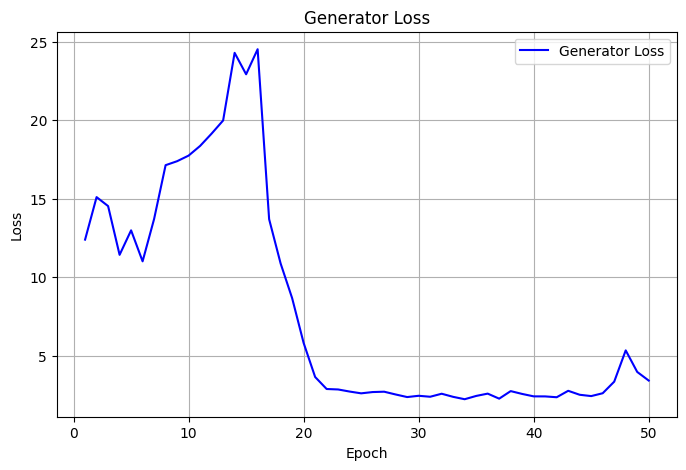

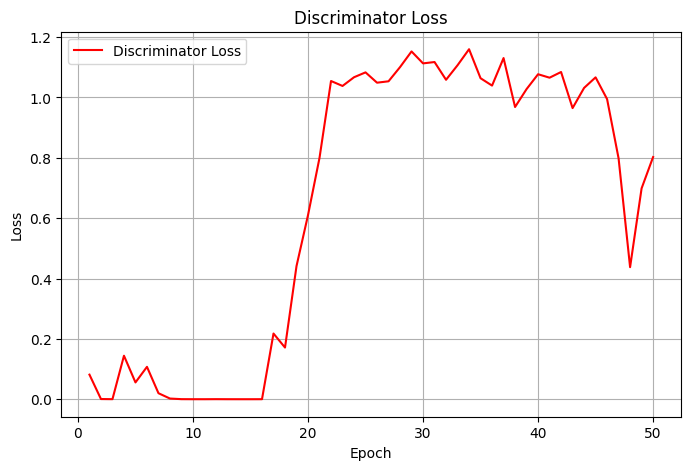

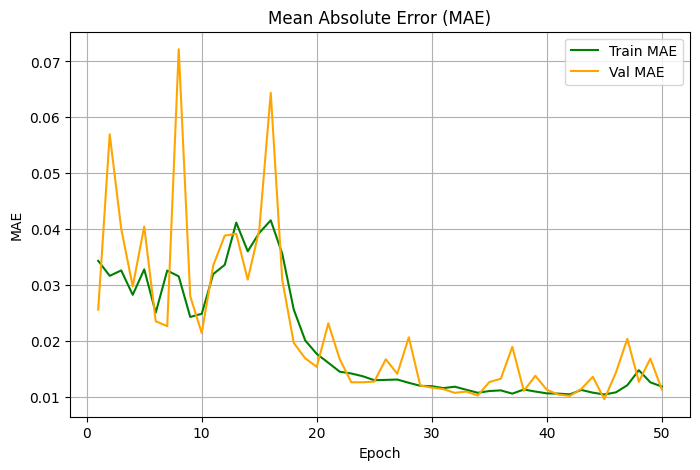

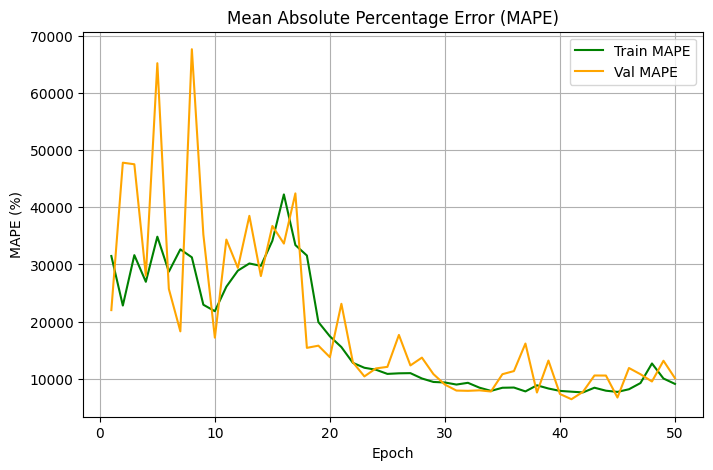

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = history["epoch"]

    # Generator Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["gen_loss"], label="Generator Loss", color="blue")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Discriminator Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["disc_loss"], label="Discriminator Loss", color="red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Discriminator Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # MAE - Training vs Validation
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["mae"], label="Train MAE", color="green")
    plt.plot(epochs, history["val_mae"], label="Val MAE", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Mean Absolute Error (MAE)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # MAPE - Training vs Validation
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history["mape"], label="Train MAPE", color="green")
    plt.plot(epochs, history["val_mape"], label="Val MAPE", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("MAPE (%)")
    plt.title("Mean Absolute Percentage Error (MAPE)")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_training_history(history)


In [ ]:
import csv

def save_history_to_csv(history, filename="history3.csv"):
    # Başlıkları tanımla
    headers = ["Epoch", "GenLoss", "DiscLoss", "Train MAE", "Train MAPE", "Val MAE", "Val MAPE"]

    with open(filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(headers)

        for i in range(len(history["epoch"])):
            writer.writerow([
                history["epoch"][i],
                round(history["gen_loss"][i], 4),
                round(history["disc_loss"][i], 4),
                round(history["mae"][i], 6),
                round(history["mape"][i], 2),
                round(history["val_mae"][i], 6),
                round(history["val_mape"][i], 2)
            ])

    print(f"[✓] Training history saved as CSV to: {filename}")

save_history_to_csv(history=history5, filename="history5.csv")




[✓] Training history saved as CSV to: history4.csv


In [ ]:
def test_model(test_dataset):
    mae_list = []
    mape_list = []

    print("\n🔍 Running test evaluation...")
    for step, (noisy_batch, clean_batch) in tqdm(enumerate(test_dataset), total=len(test_dataset), desc="Testing", ncols=100):
        # Üretilen (tahmin edilen) sesi oluştur
        generated_audio = generator(noisy_batch, training=False)

        # MAE ve MAPE hesapla
        mae = tf.reduce_mean(tf.abs(clean_batch - generated_audio)).numpy()
        mape = tf.reduce_mean(tf.abs((clean_batch - generated_audio) / (clean_batch + 1e-7))).numpy() * 100

        mae_list.append(mae)
        mape_list.append(mape)

    avg_mae = np.mean(mae_list)
    avg_mape = np.mean(mape_list)

    print(f"\n📊 Test MAE: {avg_mae:.6f}")
    print(f"📊 Test MAPE: {avg_mape:.2f}%")

    return avg_mae, avg_mape

In [ ]:
# Train Part 5

test_mae, test_mape = test_model(test_dataset)



🔍 Running test evaluation...


Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:47<00:00,  1.79it/s]


📊 Test MAE: 0.008357
📊 Test MAPE: 5941.44%


Training Part 1

🔍 Running test evaluation...
Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:45<00:00,  1.81it/s]
📊 Test MAE: 0.011288
📊 Test MAPE: 9975.16%
_____________________________________________________________

Train Part 2

🔍 Running test evaluation...
Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:49<00:00,  1.77it/s]
📊 Test MAE: 0.010215
📊 Test MAPE: 9623.50%
_________________________________________

Train Part 3

🔍 Running test evaluation...
Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:48<00:00,  1.78it/s]
📊 Test MAE: 0.012078
📊 Test MAPE: 7149.88%

________________________________________

 Train Part 4

🔍 Running test evaluation...
Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:47<00:00,  1.79it/s]
📊 Test MAE: 0.008031
📊 Test MAPE: 5947.02%
______________________________________________

Training Part 5

🔍 Running test evaluation...
Testing: 100%|████████████████████████████████████████████████████| 300/300 [02:47<00:00,  1.79it/s]
📊 Test MAE: 0.008357
📊 Test MAPE: 5941.44%
______________________________________

In [ ]:
import IPython.display as ipd
noisy_samples = []
clean_samples = []
generated_samples = []

for noisy_batch, clean_batch in test_dataset.take(1):  # tek batch al
    generated_batch = generator(noisy_batch, training=False)

    for i in range(min(20, noisy_batch.shape[0])):
        noisy = noisy_batch[i].numpy()
        clean = clean_batch[i].numpy()
        generated = generated_batch[i].numpy()

        # Stereo ise mono'ya çevir
        if len(noisy.shape) == 2:
            noisy = np.mean(noisy, axis=1)
            clean = np.mean(clean, axis=1)
            generated = np.mean(generated, axis=1)

        noisy_samples.append(noisy)
        clean_samples.append(clean)
        generated_samples.append(generated)


In [ ]:
# Birleştir (art arda diz)
noisy_concat = np.concatenate(noisy_samples)
clean_concat = np.concatenate(clean_samples)
generated_concat = np.concatenate(generated_samples)
print("🎙️ 20 Gürültülü Giriş (Yan yana dizilmiş):")
ipd.display(ipd.Audio(noisy_concat, rate=16000))

print("🔈 20 Temiz Orijinal Ses:")
ipd.display(ipd.Audio(clean_concat, rate=16000))

print("🎧 20 Modelin Tahmin Ettiği Ses:")
ipd.display(ipd.Audio(generated_concat, rate=16000))



🎙️ 20 Gürültülü Giriş (Yan yana dizilmiş):


🔈 20 Temiz Orijinal Ses:


🎧 20 Modelin Tahmin Ettiği Ses:


In [ ]:
# from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, GRU, Bidirectional, LSTM
# from tensorflow.keras.layers import Conv1DTranspose, Concatenate, Dropout
# from tensorflow.keras.models import Model

# def build_generator(input_shape=(48000, 1)):
#     inp = Input(shape=input_shape)

#     # --- Encoder (güçlü filtreler) ---
#     x = Conv1D(16, 15, strides=2, padding='same')(inp)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     c1 = x

#     x = Conv1D(32, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     c2 = x

#     x = Conv1D(64, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     c3 = x

#     x = Conv1D(128, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     c4 = x

#     x = Conv1D(256, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     c5 = x

#     # --- Bottleneck with stronger RNN ---
#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     x = Dropout(0.3)(x)
#     x = Bidirectional(LSTM(128, return_sequences=True))(x)
#     x = Dropout(0.3)(x)
#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     x = Dropout(0.3)(x)

#     # --- Decoder (matching filtre sayıları) ---
#     x = Conv1DTranspose(256, 15, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([c5, x])

#     x = Conv1DTranspose(128, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([c4, x])

#     x = Conv1DTranspose(64, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([c3, x])

#     x = Conv1DTranspose(32, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([c2, x])

#     x = Conv1DTranspose(16, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([c1, x])

#     x = Conv1DTranspose(8, 15, strides=2, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Concatenate()([inp, x])

#     out = Conv1DTranspose(1, 15, strides=1, padding='same', activation='linear')(x)


#     model = Model(inputs=inp, outputs=out, name="Generator")
#     return model
